# REINFORCE Algorithm Tutorial

## Basic imports

In [1]:
import gymnasium as gym
from tqdm.notebook import trange
import numpy as np
import torch
import matplotlib.pyplot as plt

## The Environment — Process Model

https://gymnasium.farama.org/environments/classic_control/cart_pole/

In [2]:
def take_action(env, action):
    state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    return state, reward, done

## Loss

In [3]:
def discount_rewards(rewards, discount_factor):
    ret = torch.pow(discount_factor, torch.arange(len(rewards)).float()) * rewards
    return ret / torch.max(ret)

In [4]:
def loss_fn(action_probs, disc_rewards):
    return -1 * torch.sum(disc_rewards * torch.log(action_probs))

In [5]:
def compute_loss(model, loss_function, experience, gamma):
    # states = torch.Tensor([s for (s, a, r) in experience])
    states = torch.Tensor(np.vstack([s for (s, a, r) in experience]))
    actions = torch.Tensor([a for (s, a, r) in experience])
    rewards = np.array([r for (s, a, r) in experience])
    rewards = [np.sum(rewards[i:]) for i in range(len(rewards))]
    rewards = torch.Tensor(rewards)
    # ----
    rewards_disc = discount_rewards(rewards, gamma)
    predictions = model(states)
    probs = predictions.gather(dim=1, index=actions.long().view(-1, 1)).squeeze()
    return loss_function(probs, rewards_disc)


In [6]:
def take_action(env, action):
    state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    return state, reward, done

## Decision Policies

In [7]:
def choose_exploratory_action(model, state):
    probs = model(torch.from_numpy(state).float())
    return np.random.choice(np.arange(len(probs)), p=probs.data.numpy())

In [8]:
def choose_greedy_action(model, state):
    probs = model(torch.from_numpy(state).float())
    return torch.argmax(probs).item()

In [9]:
def choose_random_action(model, state):
    probs = [0.5, 0.5]
    return np.random.choice(np.arange(len(probs)), p=np.array(probs))

## Policy Network

In [10]:
def create_policy_network():
    return torch.nn.Sequential(
        torch.nn.Linear(4, 150),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(150, 2),
        torch.nn.Softmax(dim=0)
    )

## Simulating one episode

In [11]:
def run_episode(env, model, policy, duration):
    s, _ = env.reset()
    episode = []
    for t in range(duration):
        a = policy(model, s)
        s_new, r, terminate = take_action(env, a)
        episode.append((s, a, r))
        s = s_new
        if terminate:
            break
    return episode

## Training Loop

In [12]:
def train_agent(env, model, loss_fn, optimizer, episodes_no, episode_duration, gamma):
    training_scores = []
    for episode_ndx in trange(TRAIN_EPISODES):
        episode = run_episode(env, model, choose_exploratory_action, TRAIN_DURATION)
        training_scores.append(len(episode))
        loss = compute_loss(model, loss_fn, episode, GAMMA)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return training_scores

## Testing Loop

In [13]:
def test_agent(env, model, episodes_no, episode_duration):
    testing_scores = []
    for episode_ndx in trange(TEST_EPISODES):
        episode = run_episode(env, model, choose_greedy_action, TEST_DURATION)
        testing_scores.append(len(episode))
    return testing_scores

## Visualization of Scores

In [14]:
def filter_timeseries(ts, p):
    tsf = np.nan * np.ones_like(ts)
    prev = ts[0]
    for i, v in enumerate(ts):
        tsf[i] = prev = p * prev + (1-p) * v
    return tsf

In [15]:
def visualize_scores(scores):
    scores = np.array(scores)
    filtered = filter_timeseries(scores, 0.95)
    data = np.zeros((len(scores), 2))
    data[:,0] = scores
    data[:,1] = filtered
    plt.plot(data)

## Training and Testing

In [16]:
env = gym.make("CartPole-v1")

In [17]:
model = create_policy_network()

In [18]:
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
TRAIN_DURATION = 250
TRAIN_EPISODES = 600
GAMMA = 0.99

  0%|          | 0/600 [00:00<?, ?it/s]

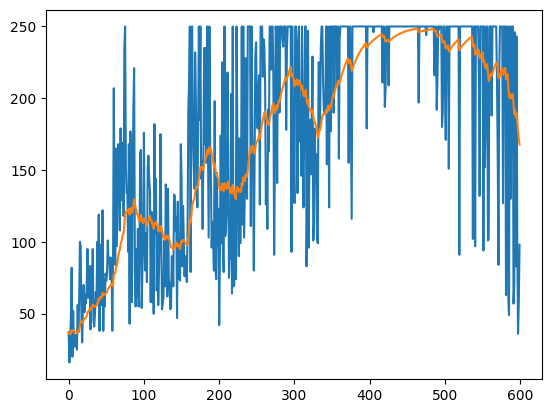

In [20]:
training_scores = train_agent(env, model, loss_fn, optimizer, TRAIN_EPISODES, TRAIN_DURATION, GAMMA)
visualize_scores(training_scores)

  0%|          | 0/600 [00:00<?, ?it/s]

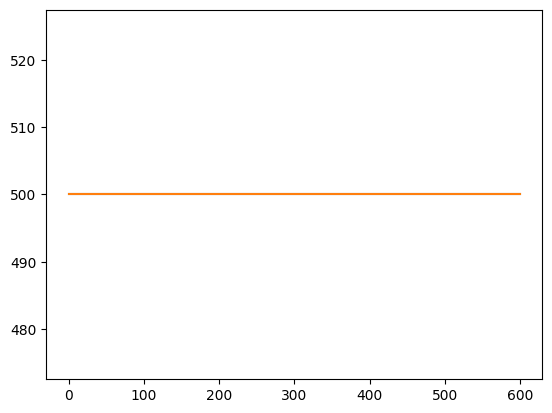

In [21]:
TEST_DURATION = 500
TEST_EPISODES = 600
testing_scores = test_agent(env, model, TEST_EPISODES, TEST_DURATION)
visualize_scores(testing_scores)